In [78]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn as nn

from qibo import Circuit, gates, hamiltonians, set_backend, construct_backend

from qiboml.models.encoding import DataReuploading
from qiboml.models.decoding import Expectation
from qiboml.interfaces.pytorch import QuantumModel
from qiboml.operations.differentiation import PSR

In [81]:
set_backend("qiboml", platform="pytorch")

nqubits = 1
nlayers = 5

# Encoding layer
encoding_circ = DataReuploading(nqubits=nqubits, nlayers=nlayers, encoding_gate=gates.RX)

# Decoding layer
decoding_circ = Expectation(
    nqubits=nqubits, 
    backend=construct_backend("numpy")
)

# Trainable layer
trainable_circ  = Circuit(nqubits)
for q in range(nqubits):
    trainable_circ.add(gates.RY(q=q, theta=np.random.randn()))
    trainable_circ.add(gates.RZ(q=q, theta=np.random.randn()))
if nqubits > 1:
    [trainable_circ.add(gates.CNOT(q%nqubits, (q+1)%nqubits) for q in range(nqubits))]

trainable_circ.draw()

# The whole model
model = QuantumModel(
    encoding=encoding_circ,
    circuit=trainable_circ,
    decoding=decoding_circ,
    differentiation=PSR(),
)

model.draw()

[Qibo 0.2.17|INFO|2025-02-25 16:58:46]: Using qiboml (pytorch) backend on cpu


0: ─RY─RZ─
0: ─RX─RY─RZ─RX─RY─RZ─RX─RY─RZ─RX─RY─RZ─RX─RY─RZ─


In [67]:
# Prepare the training dataset (using f(x) = sin(x) as the target function)
def f(x):
    return 1 * torch.sin(x)  ** 2 - 0.3 * torch.cos(x) 

num_samples = 30
x_train = torch.linspace(0, 2 * np.pi, num_samples, dtype=torch.float32).unsqueeze(1)
y_train = f(x_train)

y_train = 2 * ( (y_train - min(y_train)) / (max(y_train) - min(y_train)) - 0.5 )

In [69]:
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

In [70]:
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    # Use torch.stack to get a tensor of shape (100, 1, 1)
    y_pred = torch.stack([model(x) for x in x_train])
    # Remove the extra singleton dimension so that y_pred has shape (100, 1)
    y_pred = y_pred.squeeze(-1)
    
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

Epoch 0: Loss = 0.6918910145759583
Epoch 10: Loss = 0.15788255631923676
Epoch 20: Loss = 0.061538711190223694
Epoch 30: Loss = 0.03144393488764763
Epoch 40: Loss = 0.01362784393131733
Epoch 50: Loss = 0.007351264823228121
Epoch 60: Loss = 0.005263514816761017
Epoch 70: Loss = 0.0048614623956382275
Epoch 80: Loss = 0.004612084943801165
Epoch 90: Loss = 0.0044062393717467785


In [71]:
predictions = torch.stack([model(x) for x in x_train])
y_pred = y_pred.squeeze(-1)

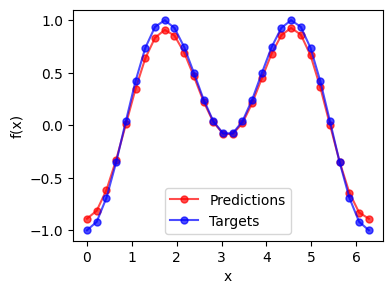

In [77]:
plt.figure(figsize=(4, 4 * 6 / 8), dpi=100)
plt.plot(
    x_train, 
    y_pred.detach().numpy(), 
    marker=".",
    markersize=10,
    color="red", 
    label="Predictions",
    alpha=0.7
)
plt.plot(
    x_train, 
    y_train,
    marker=".",
    markersize=10,
    color="blue", 
    label="Targets",
    alpha=0.7
)
plt.xlabel(r"x")
plt.ylabel(r"f(x)")
plt.legend()
plt.show()

In [101]:
print(model.differentiation)

None
